In [1]:
from matplotlib import pyplot as plt
from matplotlib import cm
from pathlib import Path
from glob import glob
import numpy as np
import cv2 as cv

# setting the paths for the input and the output folders
main_folder = Path.cwd()
train_path = main_folder / 'Input' / 'train_data'
test_path = main_folder / 'Input' / 'test_data'
op_path = main_folder / 'Results'

# Histogram model:

* The histogram model has been run 2 times, for a large histogram array and small histogram array.
* Changing the histogram model size plays a significant role in the results we get, which will be discussed at the end.
* But, in general, larger the histogram, the more fine-tuned model we will get. This may sometimes yield poor results (that is, more false negatives), especially for smaller datasets.
* On the other hand, when the histogram is small, we may get better results but this model may also classify noise as skin (that is, more false positives).
* Whatever the histogram size or threshold values are fixed, the general approach for training a histogram model is:
    1. Initialize an empty histogram with certain size.
    2. Take a training image and convert it to HSV values in order to extract the hue and saturation.
    3. Map the hue and saturation pair (one for each pixel in the image) to a corresponding index in the histogram model.
    4. Increment the value at that indices by 1.
    5. Repeat steps 2, 3, and 4 for each training image.
    6. Normalize the histogram values between 0 and 1.
* Now, that we have trained a histogram model, we can test it on unseen images.
* We basically have a model that will tell us at what hue and saturation levels were the most skin pixels noticed.
* We can use thresholding to remove the smaller values, because these could be noise from the training images and not actual skin pixels.
* To test the unseen images, we can follow these steps:
    1. Take an image and convert it to HSV values in order to extract the hue and saturation.
    2. For each pixel, map the hue and saturation values to our histogram model indices.
    3. If the value at this index is greater than the threshold, classify it as skin else not skin.
    4. Repeat steps 1, 2, and 3 for each testing image.

## Histogram model run 1 (model size - 255 by 255):

* Here we are trying a larger histogram size.
* Generally, to get the best results for type of histogram model, we will need lots of images.
* The mean value turned out a good estimate for thresholding and consistently gave good results. Hence mean is used for both the runs.

In [2]:
'''
Creating a histogram model from the training images (for large model size)
'''

# initialization and setting parameters for quantization
VALUES_PER_INDEX = 1
h_size = s_size = (256 // VALUES_PER_INDEX) + 1
histogram_model = np.zeros(shape=(h_size, s_size))

# these variables will help in computing the mean for the gaussian model later on
h_sum = s_sum = 0
N = 0

# reading each image and training the model
for file in glob(str(train_path / '*.jpg')):
    image = cv.imread(file, -1)
    # converting the image to HSV format to get the Hue and Saturation values
    HSV_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    
    for row in HSV_image:
        for H, S, _ in row:
            h_index = H // VALUES_PER_INDEX
            s_index = S // VALUES_PER_INDEX
            histogram_model[h_index, s_index] += 1
            
            # again calculations in this part will be used later for the gaussian model
            h_sum += H
            s_sum += S
            N += 1
    
# normalizing the values in the model between 0 and 1
histogram_model = histogram_model / histogram_model.max()       

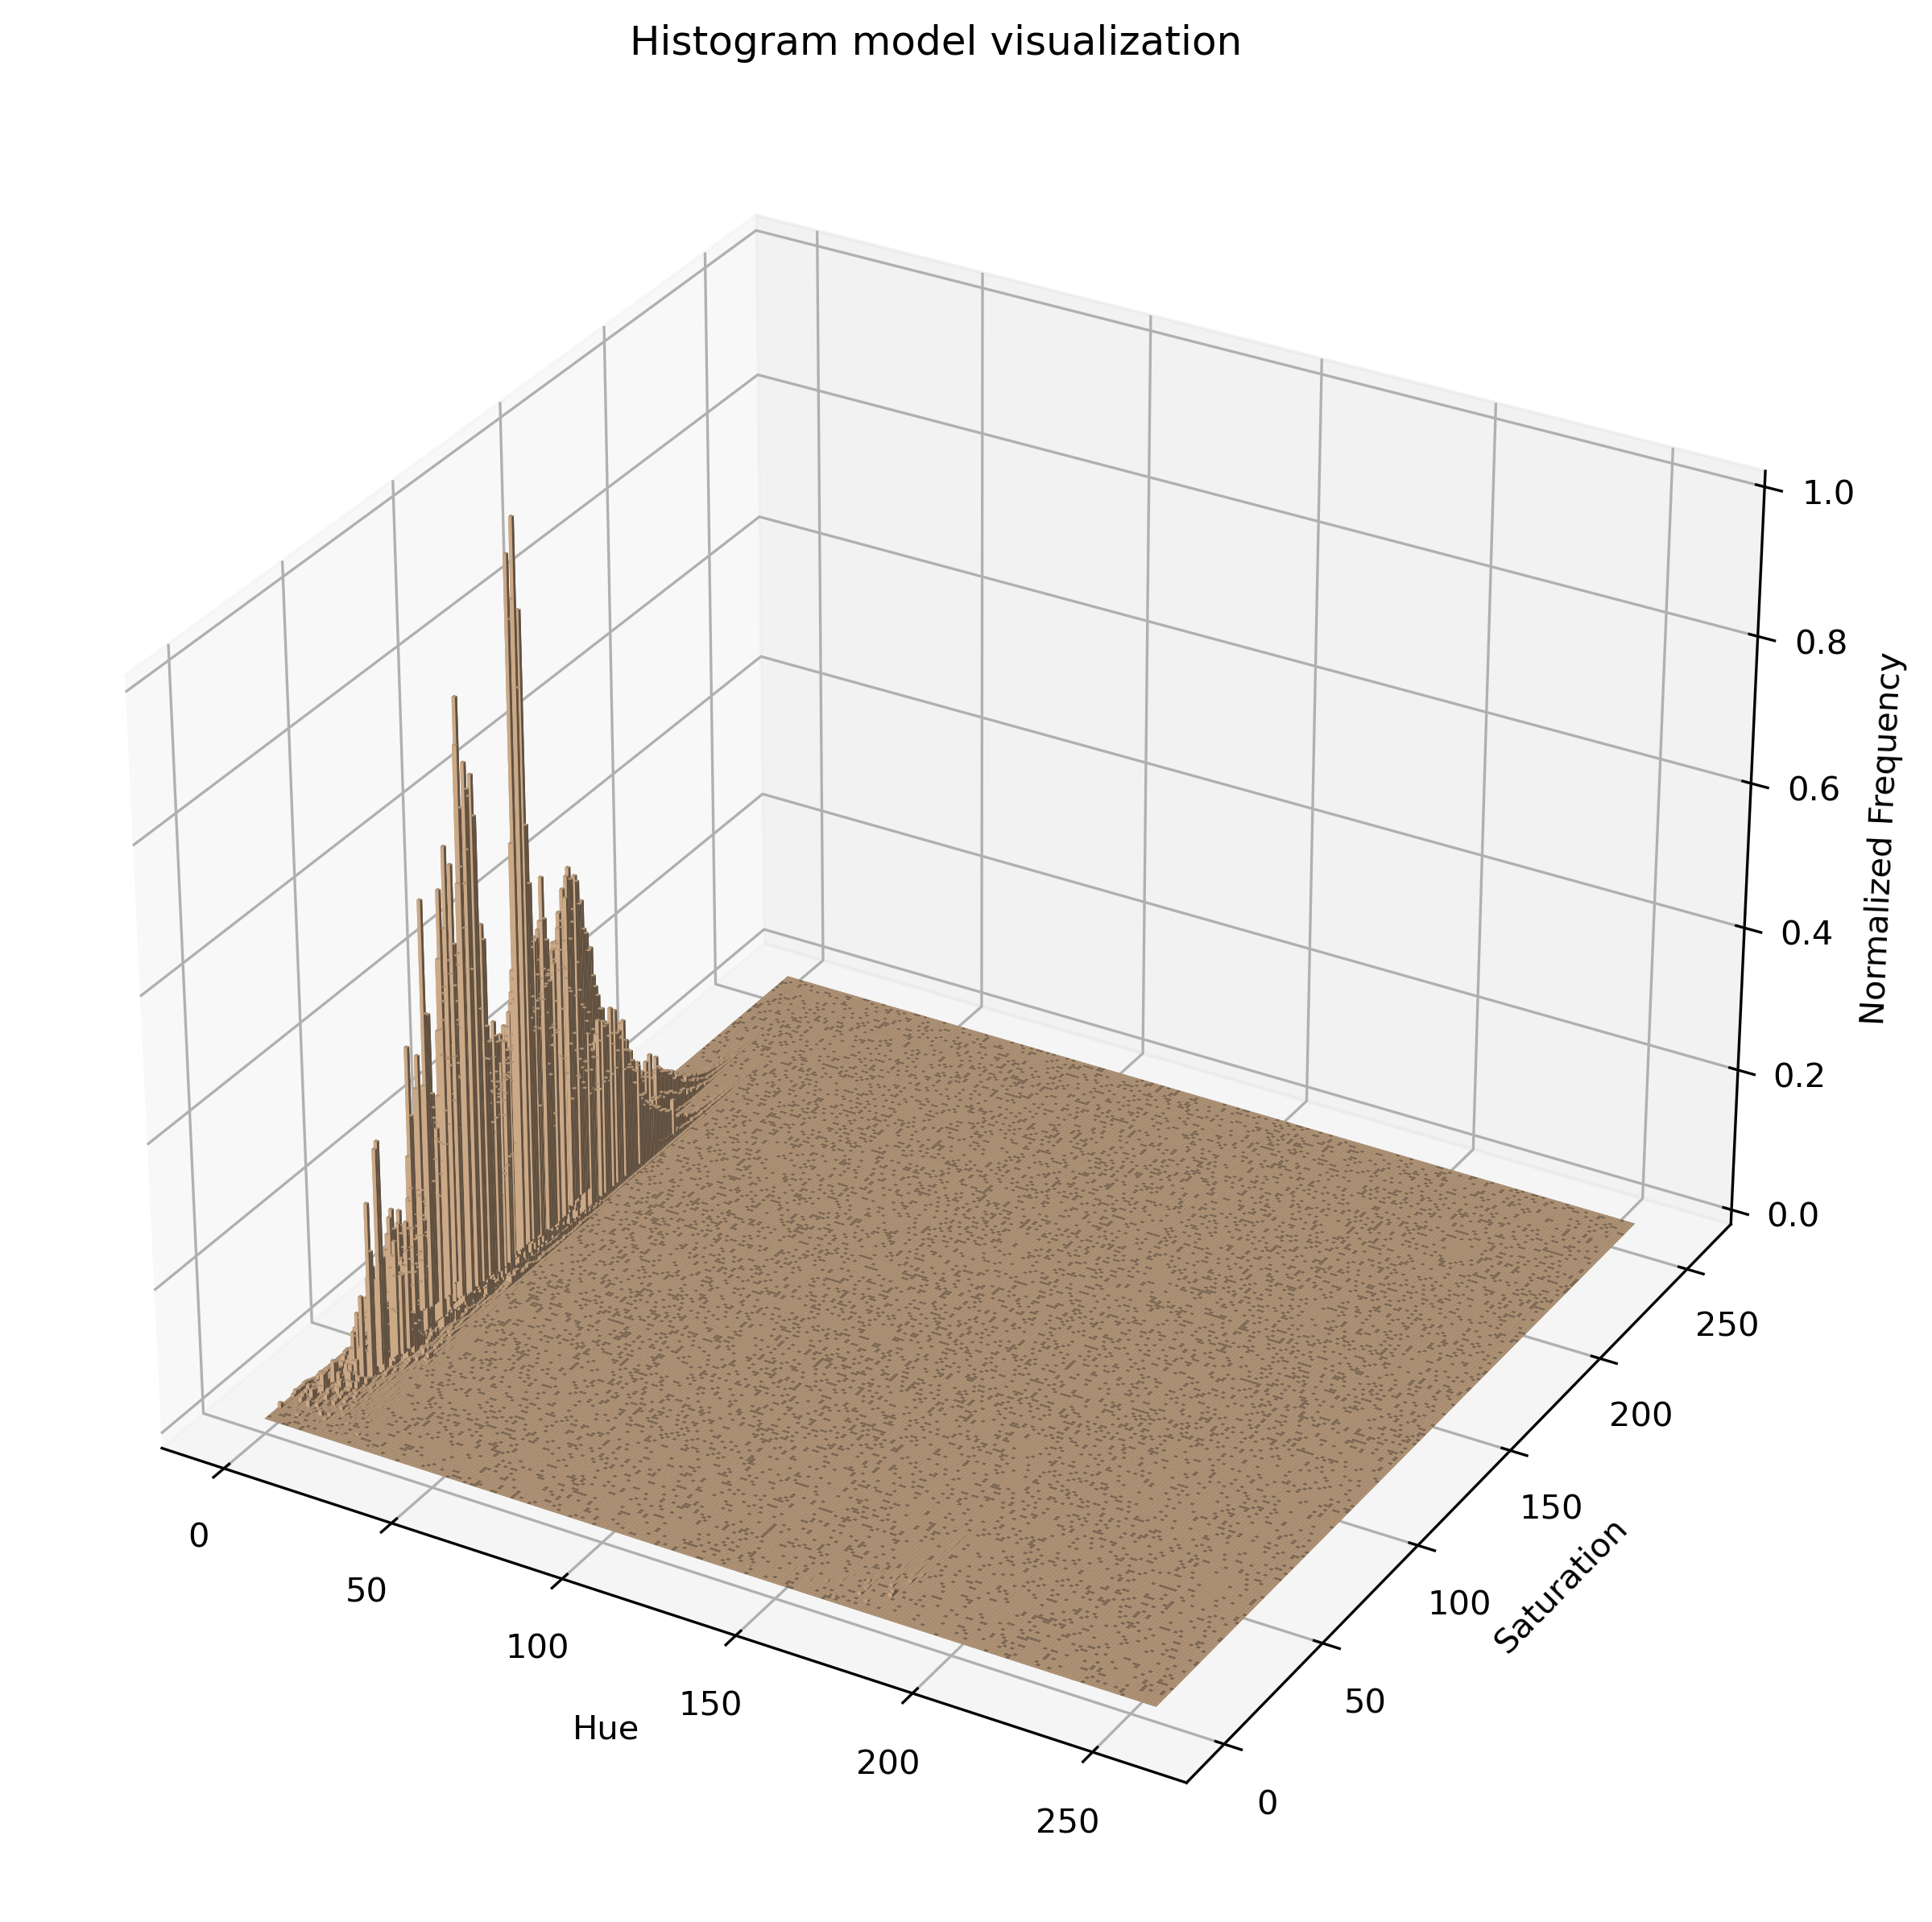

In [3]:
'''
visualizing our histogram model using a 3D bar plot
'''

# pre-processing
size = histogram_model.shape[0]
y, x = np.meshgrid(np.arange(0, size), np.arange(0, size))
x, y, z = x.flatten(), y.flatten(), np.zeros(size*size)
dx, dy, dz = 1, 1, histogram_model.flatten()

# plotting
fig = plt.figure(figsize=(10, 10), dpi=300)
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Normalized Frequency')
ax.set_title('Histogram model visualization')
bar = ax.bar3d(x, y, z, dx, dy, dz, color=(0.9, 0.75, 0.6))
plt.show()

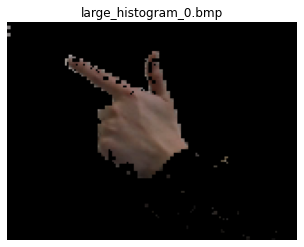

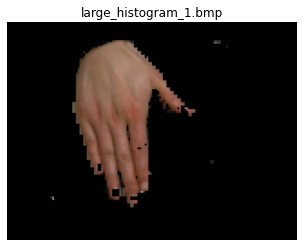

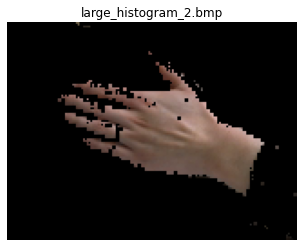

In [4]:
'''
testing our histogram model on the test images
'''

threhsold = histogram_model.mean()
for file_no, file in enumerate(glob(str(test_path / '*.bmp'))):
    image = cv.imread(file, -1)
    HSV_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    res = np.zeros(shape=image.shape, dtype='uint8')
    
    for i, row in enumerate(HSV_image):
        for j, (H, S, _) in enumerate(row):
            h_index = H // VALUES_PER_INDEX
            s_index = S // VALUES_PER_INDEX
            if histogram_model[h_index, s_index] > threhsold:
                res[i, j, :] = image[i, j, :]
             
    # plotting the resulting skin segmentation
    plt.imshow(res[:, :, ::-1])
    plt.title(f'large_histogram_{file_no}.bmp')
    plt.axis('off')
    plt.show()
    
    # writing the result to the output folder
    cv.imwrite(filename=str(op_path / f'large_histogram_{file_no}.bmp'), img=res)

## Histogram model run 2 (model size - 25 by 25):

* Here we are trying a smaller histogram size.
* This type of model is recommended when we don't have a lot of training images and still want to achieve good results.

In [5]:
'''
Creating a histogram model from the training images (for small model size)
'''

# initialization and setting parameters for quantization
VALUES_PER_INDEX = 10
h_size = s_size = (256 // VALUES_PER_INDEX) + 1
histogram_model = np.zeros(shape=(h_size, s_size))

# reading each image and training the model
for file in glob(str(train_path / '*.jpg')):
    image = cv.imread(file, -1)
    # converting the image to HSV format to get the Hue and Saturation values
    HSV_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    
    for row in HSV_image:
        for H, S, _ in row:
            h_index = H // VALUES_PER_INDEX
            s_index = S // VALUES_PER_INDEX
            histogram_model[h_index, s_index] += 1
                        
# normalizing the values in the model between 0 and 1
histogram_model = histogram_model / histogram_model.max()   

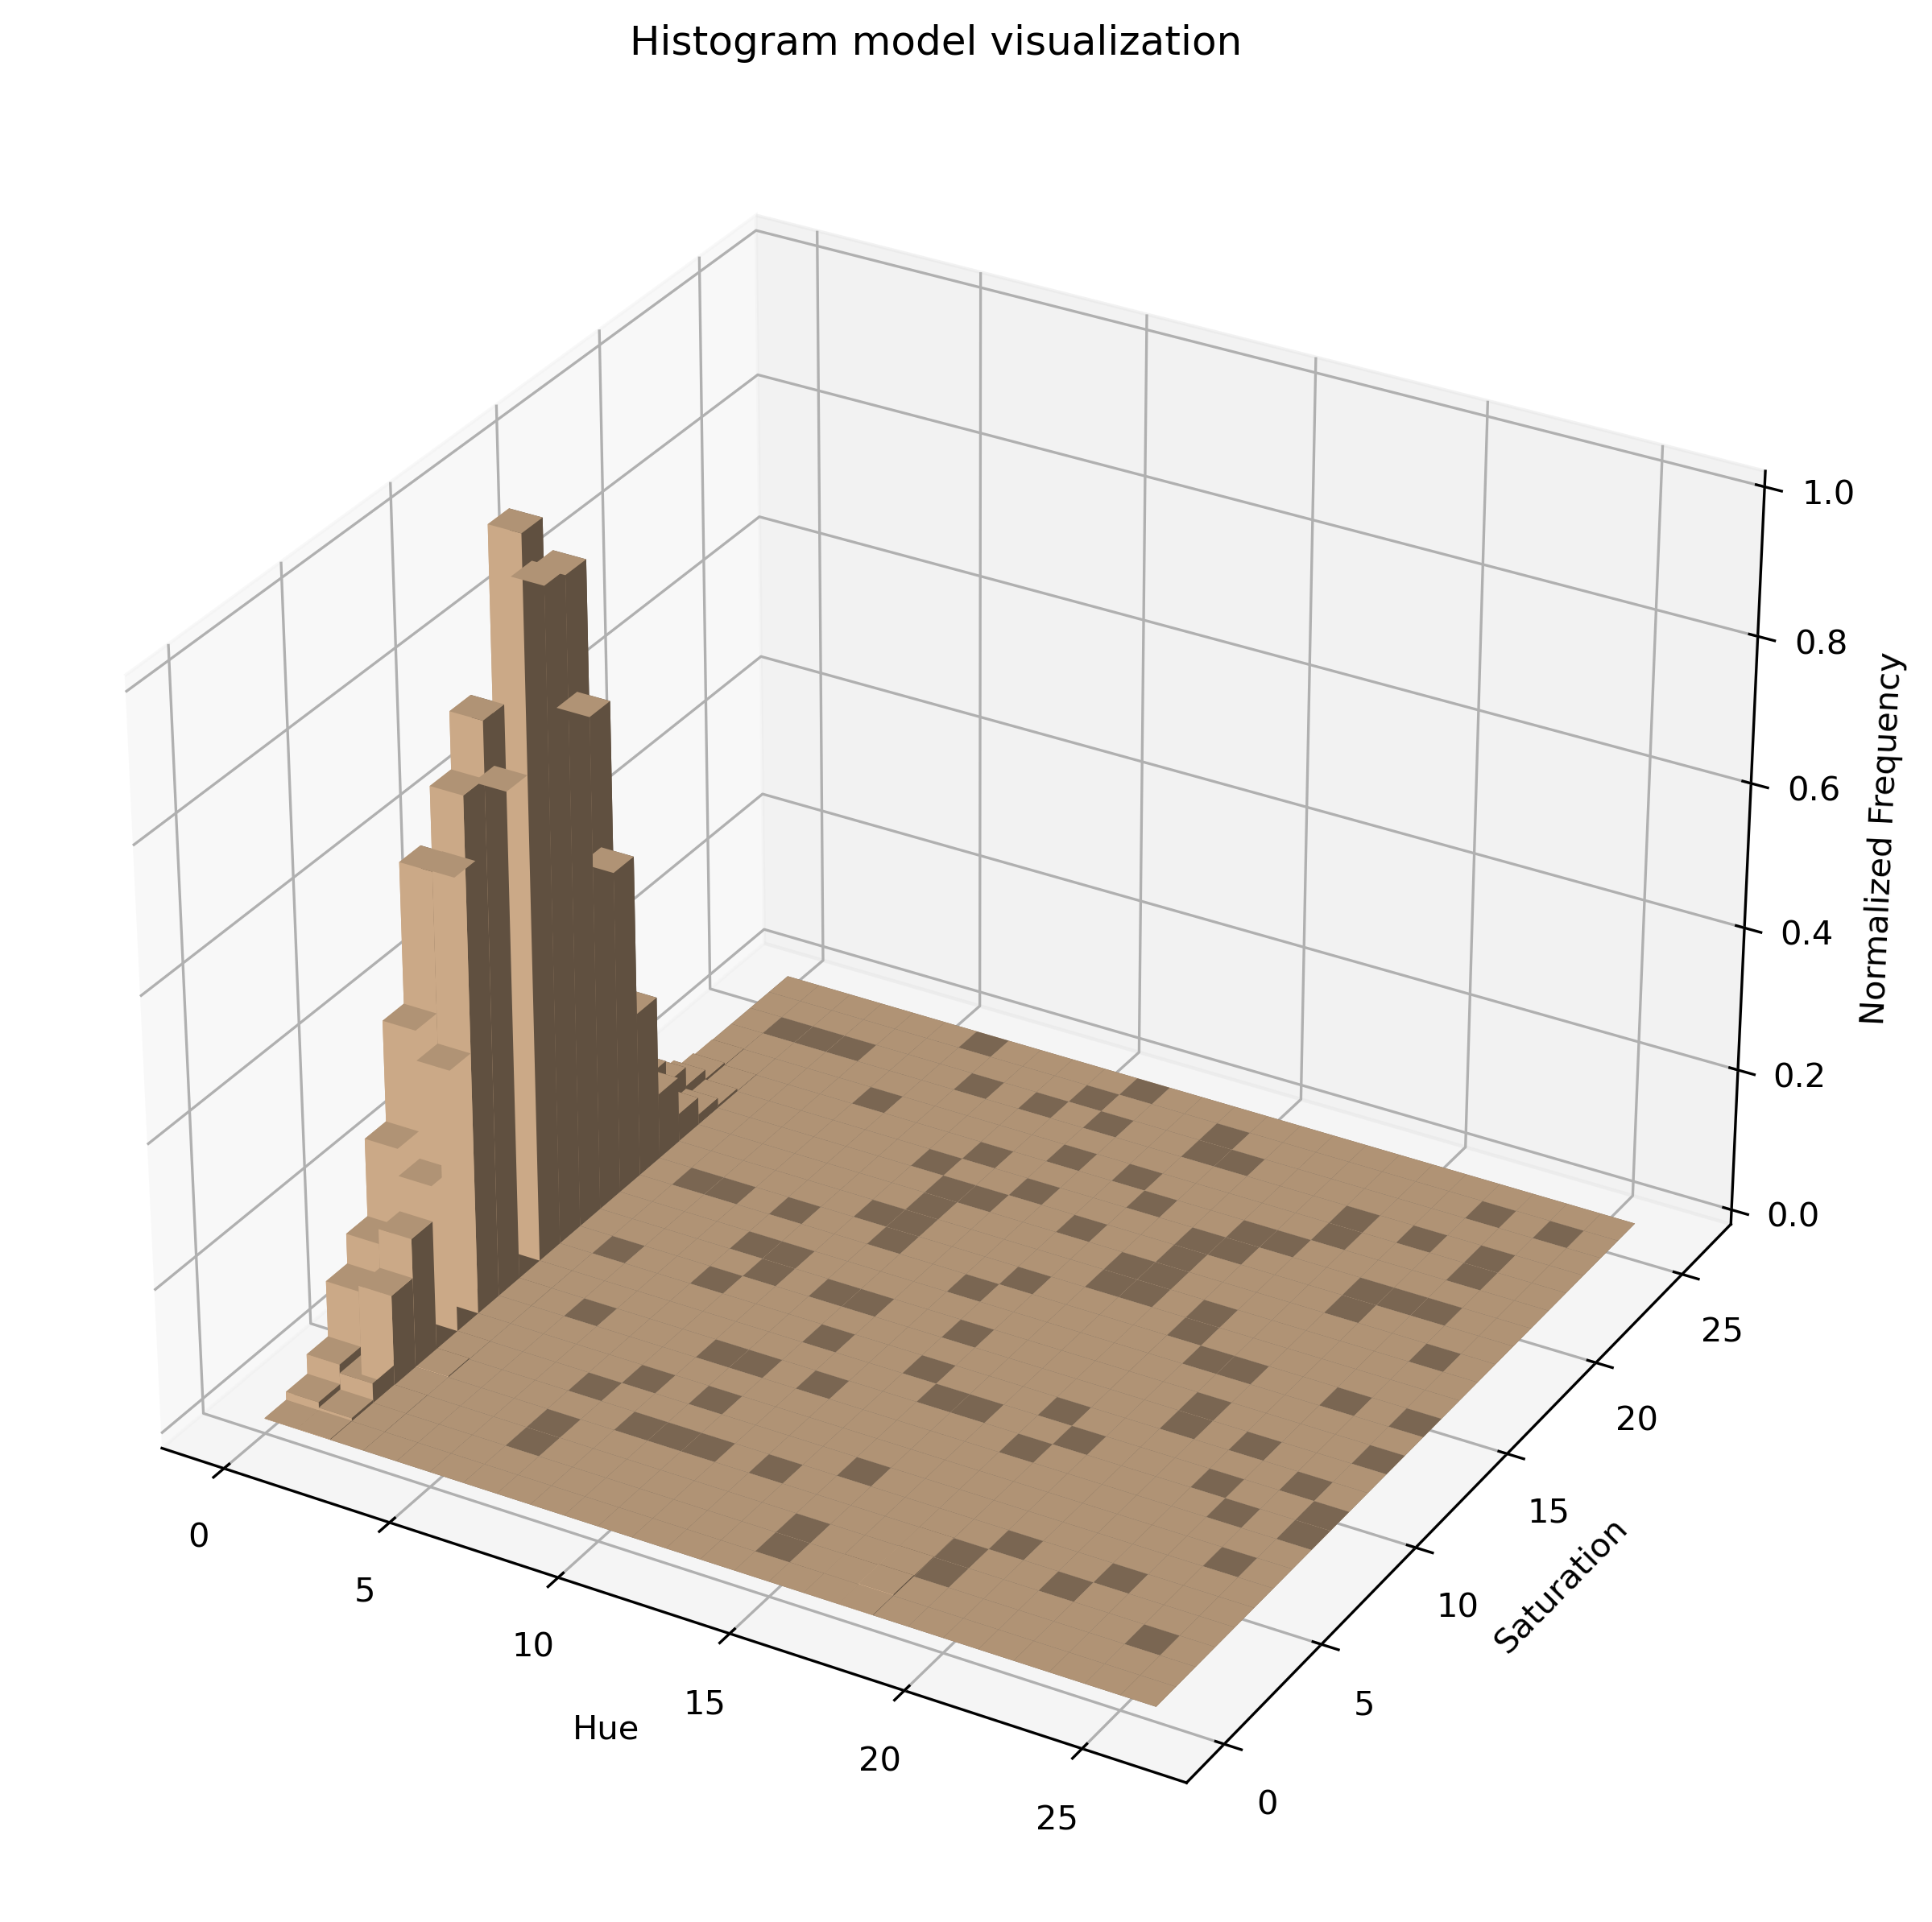

In [6]:
'''
visualizing our histogram model using a 3D bar plot
'''

# pre-processing
size = histogram_model.shape[0]
y, x = np.meshgrid(np.arange(0, size), np.arange(0, size))
x, y, z = x.flatten(), y.flatten(), np.zeros(size*size)
dx, dy, dz = 1, 1, histogram_model.flatten()

# plotting
fig = plt.figure(figsize=(10, 10), dpi=300)
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Normalized Frequency')
ax.set_title('Histogram model visualization')
bar = ax.bar3d(x, y, z, dx, dy, dz, color=(0.9, 0.75, 0.6))
plt.show()

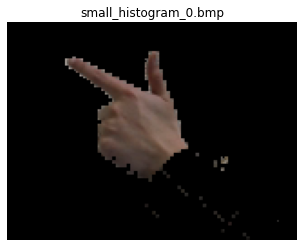

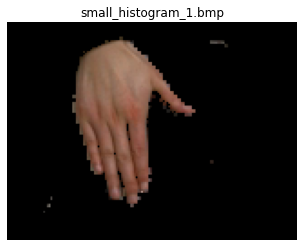

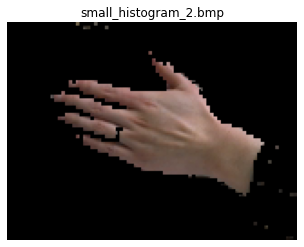

In [7]:
'''
testing our histogram model on the test images
'''

threhsold = histogram_model.mean()
for file_no, file in enumerate(glob(str(test_path / '*.bmp'))):
    image = cv.imread(file, -1)
    HSV_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    res = np.zeros(shape=image.shape, dtype='uint8')
    
    for i, row in enumerate(HSV_image):
        for j, (H, S, _) in enumerate(row):
            h_index = H // VALUES_PER_INDEX
            s_index = S // VALUES_PER_INDEX
            if histogram_model[h_index, s_index] > threhsold:
                res[i, j, :] = image[i, j, :]
          
    # plotting the resulting skin segmentation
    plt.imshow(res[:, :, ::-1])
    plt.title(f'small_histogram_{file_no}.bmp')
    plt.axis('off')
    plt.show()
    
    # writing the result to the output folder
    cv.imwrite(filename=str(op_path / f'small_histogram_{file_no}.bmp'), img=res)

# Gaussian model:

* Gaussian model is based on the probabilistic skin model.
* That is, for a given hue and saturation, the model will compute the probability of that pixel being a skin pixel.
* Then we can threshold this probability to get the final answer.
* Gaussian models are more computationally intensive than the histogram model. This is because instead of just voting on certain hue and saturation, here we need to compute the expected values and the covariance matrix from the data.
* But the gaussian model uses much less memory than the histogram model. Here, we don't need huge 2D matrix to store the model.
* We only need to store 6 parameters (2 for mean and 4 for the covariance matrix).
* Hence, gaussian model is also called a parametric model, while histogram is called a non-parametric model.
* Due to its probabilistic nature, gaussian model may sometimes yield better results.
* The general approach is,
    1. Go through all the images and compute the mean values and the covariance matrix.
    2. Use these values on the test images to get the probability.
    3. Classify depending on the probability.
* The likelihood or probability formula is a simple formula based on the hue, saturation, mean, and covariance between hue and saturation.

In [8]:
'''
Creating a gaussian model from the training images
'''

# calculating the Expected value (Mean) and Covariance matrix
E = np.array([[h_sum / N], [s_sum / N]])
C = np.zeros(shape=(2, 2), dtype='float32')

# reading each image, converting to the HSV values and training the gaussian model
for file in glob(str(train_path / '*.jpg')):
    image = cv.imread(file, -1)
    HSV_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    
    for row in HSV_image:
        for H, S, _ in row:
            h_prime = H - E[0][0]
            s_prime = S - E[1][0]
            C += np.array([[h_prime**2, h_prime*s_prime], [s_prime*h_prime, s_prime**2]])            
C /= N

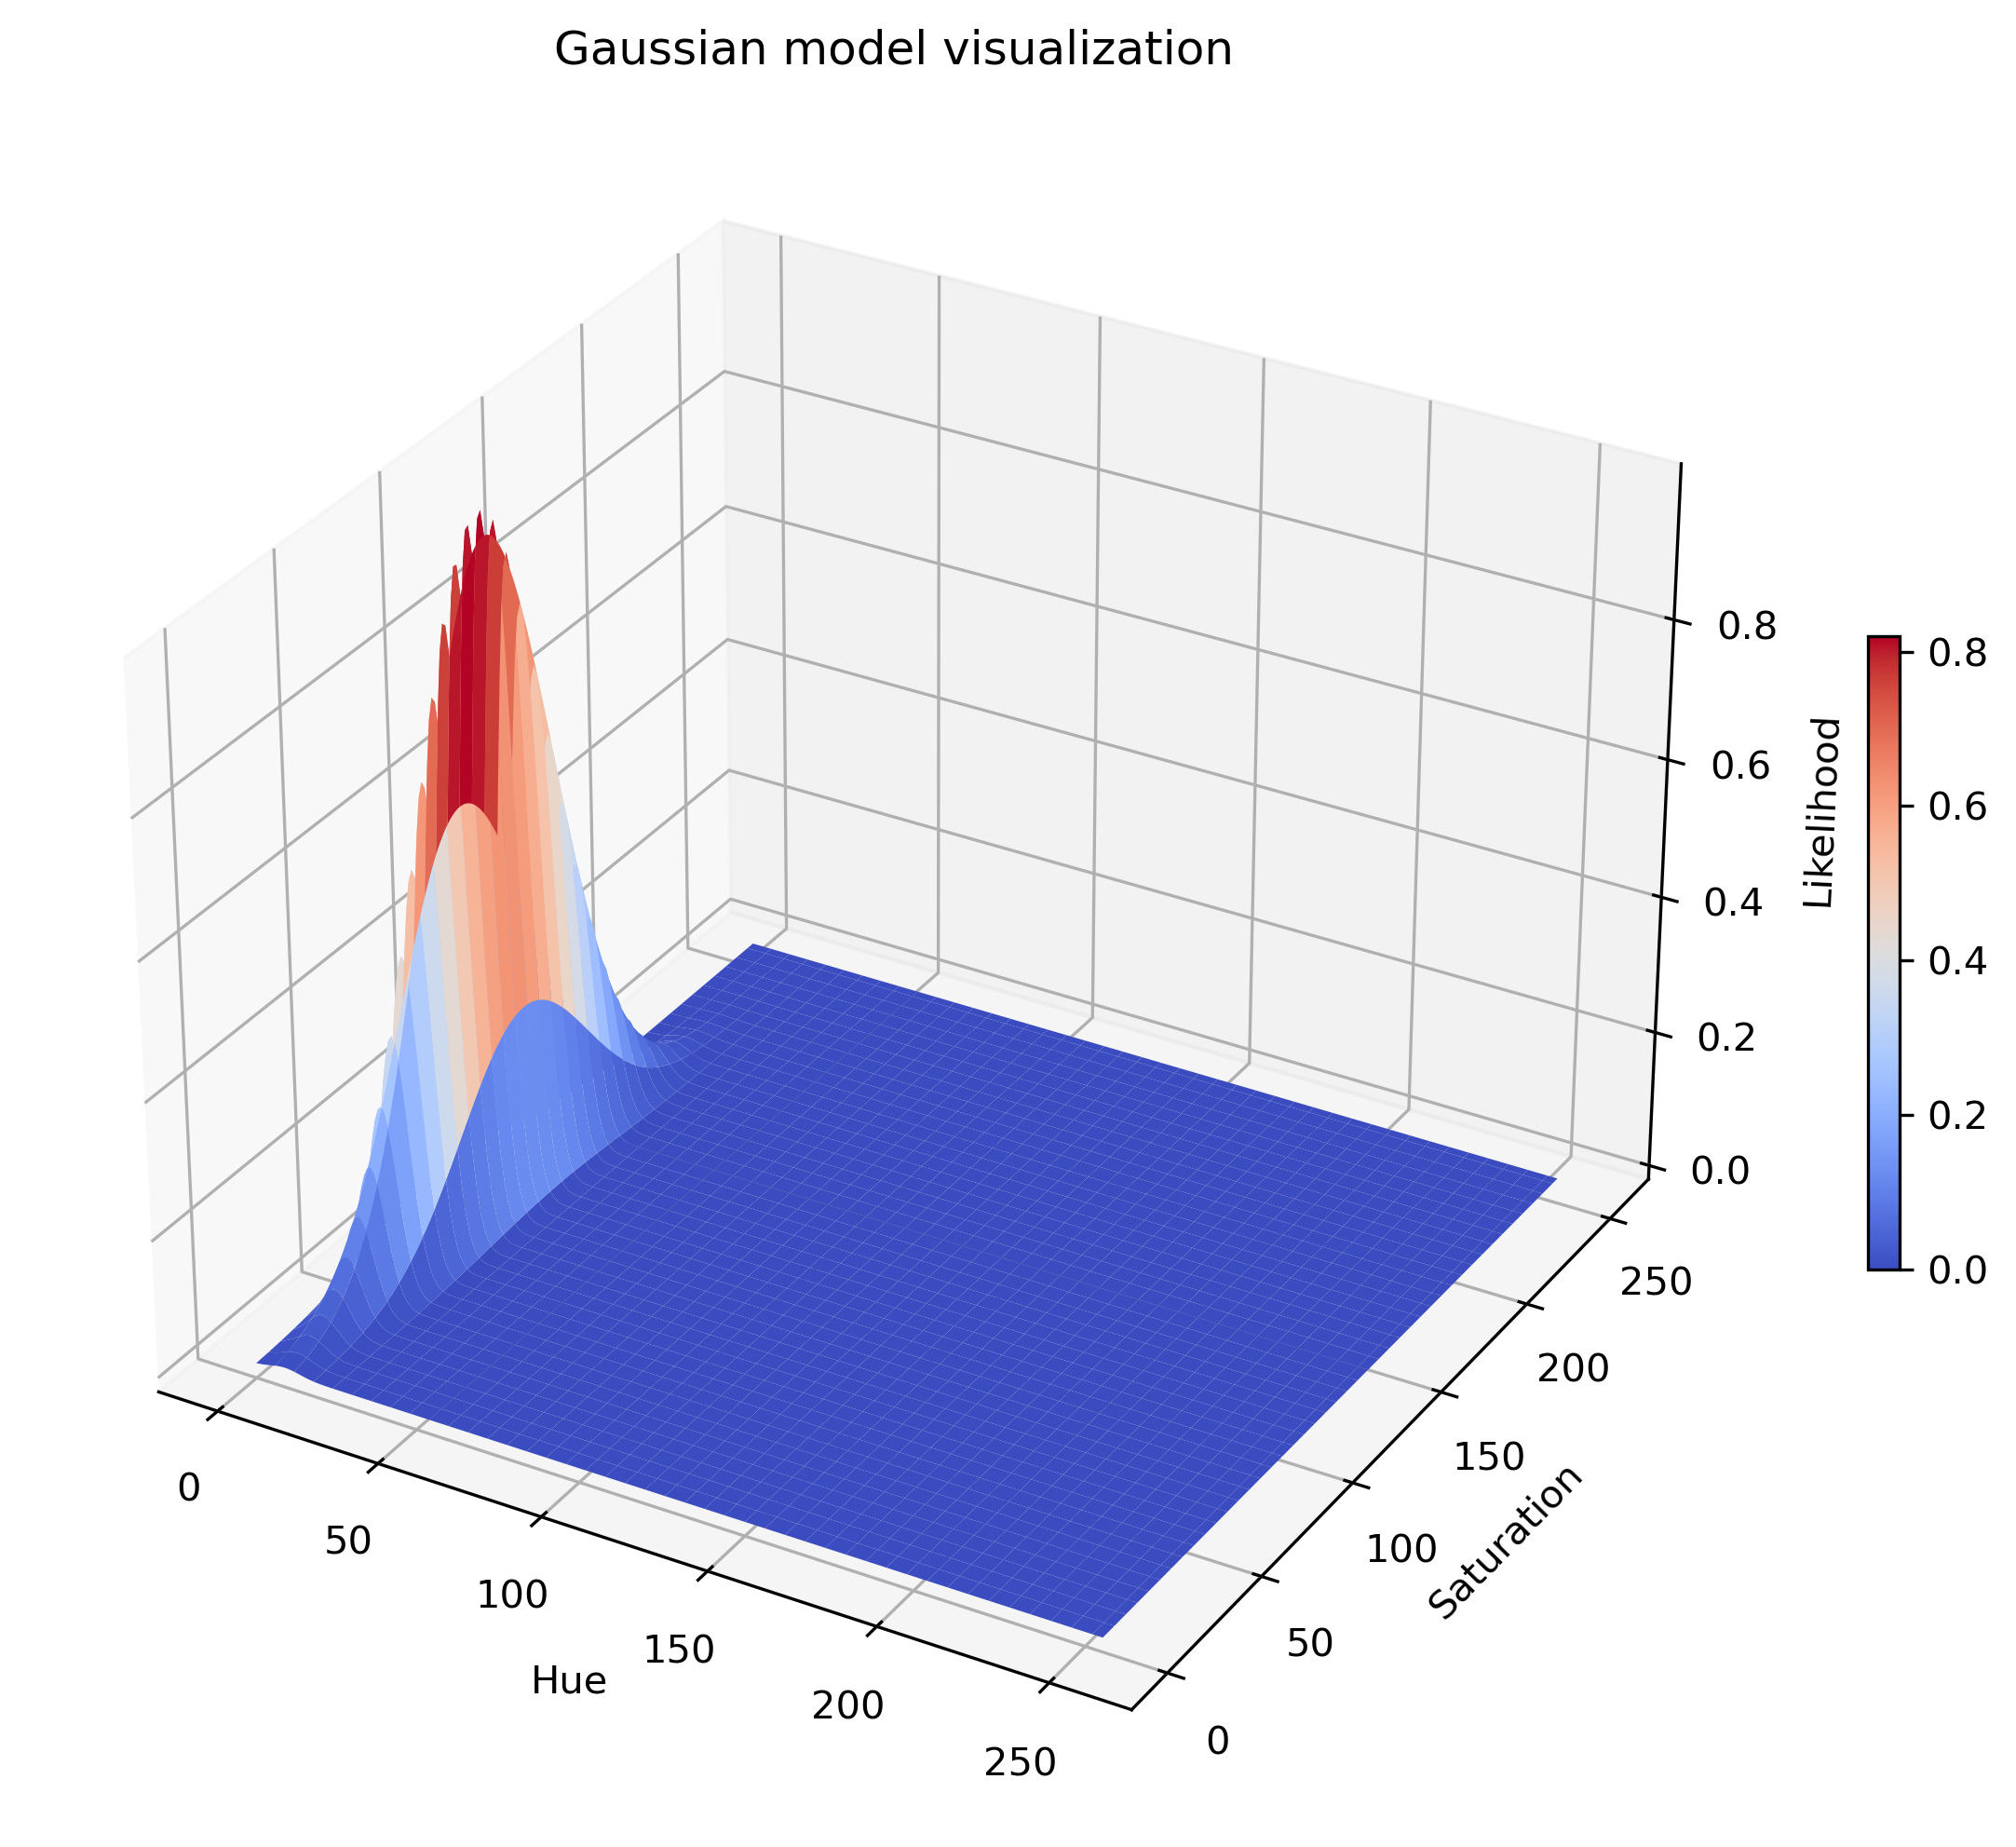

In [9]:
'''
Visualizing our gaussian model.
NOTE: Here we are calculating the likelihood (probability) from our gaussian model for every possble pair of values 
of hue and saturation. This is only for visualization, and we don't need to precompute these values.
As we will see later on the testing data, that the probabilities can be computed on the go.
'''

# calculating probability values for every possible pair of hue and saturation (only for visualization)
gaussian_model = np.empty((256, 256))
for H in range(256):
    for S in range(256):
        x = np.array([[H], [S]])
        gaussian_model[H, S] = np.exp(-0.5 * (x - E).T @ np.linalg.inv(C) @ (x - E))

# plotting the gaussian curve
fig = plt.figure(figsize=(10, 10), dpi=300)
ax = fig.gca(projection='3d')
ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Likelihood')
ax.set_title('Gaussian model visualization')
saturation, hue = np.meshgrid(np.arange(0, gaussian_model.shape[0], 1), np.arange(0, gaussian_model.shape[1], 1))
surf = ax.plot_surface(hue, saturation, gaussian_model, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.3)
plt.show()

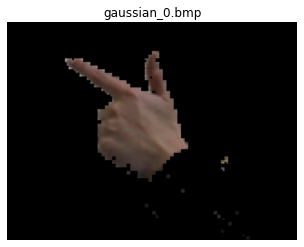

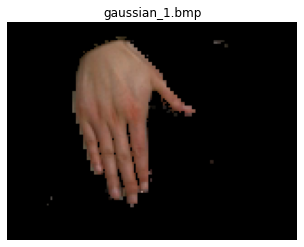

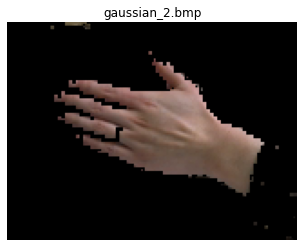

In [10]:
'''
testing our gaussian model on the test images
'''

threhsold = 0.05
for file_no, file in enumerate(glob(str(test_path / '*.bmp'))):
    image = cv.imread(file, -1)
    HSV_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    res = np.zeros(shape=image.shape, dtype='uint8')
    
    for i, row in enumerate(HSV_image):
        for j, (H, S, _) in enumerate(row):
            x = np.array([[H], [S]])
            
            # calculating the probability from the gaussian curve
            likelihood = np.exp(-0.5 * (x - E).T @ np.linalg.inv(C) @ (x - E))
            if likelihood > threhsold:
                res[i, j, :] = image[i, j, :]
             
    # plotting the resulting skin segmentation
    plt.imshow(res[:, :, ::-1])
    plt.title(f'gaussian_{file_no}.bmp')
    plt.axis('off')
    plt.show()
    
    # writing the result to the output folder
    cv.imwrite(filename=str(op_path / f'gaussian_{file_no}.bmp'), img=res)

# Result analysis:

* As we can observe, both the models have done a good job in classifying the skin parts from the non-skin parts of the image.
* For the bigger histogram model, some pixels in the middle of the hand and on the fingers were classified as non-skin pixels.
* We could have improved this by doing either of the two things:
    1. Increase the training dataset size.
    2. Decrease the threshold.
* Both the methods will improve the result, but they come with certain caveats.
* Increasing the training size means more time invested in training, which may not be always desireable.
* Decreasing the threshold means risking classifying noise as skin.
* But, if we don't want to choose either of the two options, we have another technique to improve the result: changing the quantization of the histogram model.
* This may not be always best, but will work for our small train and test dataset.
* Previously a hue value, say 100, will map to 100th index, 101 will map to 101st index, and so on.
* But now, multiple values will map and vote for the same index.
* For example, in the second run, all hue and saturation values below 26 will map to the 0th index. Basically we have combined the neighboring values to vote (increment) for the same value.
* In the second run, this improved the results as the pixels in the middle of the hand and on the fingers are now correctly classified as skin pixels, without including a lot of noise.
* Similarly, for the gaussian model, we have achieved excellent results. The ring on one of the finger is classified as non-skin.
* We can see in the plots, our models have learned that around the low hue range, we are more likely to encounter the skin pixels. And everywhere else, we are least likely to find any skin pixels.
* So, from the visualization, we know that both the models have learned similar knowledge from the training images, but their way of reaching and learning it is different.
* Finally, all the models couldn't smoothly identify the edge of the skin in the image. We can observe jagged lines at the edges in the classification.
* This means the models could not learn enough from the training data. This could be resolved by collecting more images in a wide variety of scenarios and lighting conditions.